In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import yaml

# Distgen basic usage
--------------------

Distgen supports nearly arbitrary generation of 6D + time particle coordinates.  

# Generator

Generator class defines the main object that creates a beam distribution.  Typical usage is to supply the `Generator.__init__(input,verbose)` with an input file name and a verbose integer value to control the level of output printed to the user.  Input file names can be either json or YAML.  

In [2]:
input_file = 'data/rad.gaussian.in.yaml'
# Create a generator object
from distgen import Generator
gen = Generator(input_file, verbose=0) 

Printing a Generator object displays the input data read from a distgen input file:

In [3]:
print(gen)

<disgten.Generator with input: 
n_particle: 200000
output:
  file: rad.gaussian.out.txt
  type: gpt
r_dist:
  sigma_xy:
    units: mm
    value: 2
  type: radial_gaussian
random_type: hammersley
start:
  MTE:
    units: meV
    value: 150
  type: cathode
t_dist:
  max_t:
    units: ps
    value: 2
  min_t:
    units: ps
    value: -2
  type: uniform
total_charge:
  units: pC
  value: 10

>


The input structure allows for four top levels: generator, beam, {variable}_dists, transforms, and output.  Any other input will throw an exception when attempting to create the beam:

In [4]:
try:
    gen.input['foo']='bar'
    gen.beam()   
except Exception as ex:
    print(ex)

Unexpected distgen input parameter: foo


Distgen generator.input is a nested dictionary by design.  While this logically organizes the input, it can be somewhat cumbersome for changing input.  Thus the generator.input dictionary can be accessed with pure strings via the [...] method with a flattened dictionary (nested keys separated by ':'):

In [5]:
gen['start']

{'MTE': {'units': 'meV', 'value': 150}, 'type': 'cathode'}

Brackets can also be used to set parameters:

In [6]:
gen['start:MTE:value']=120
print('New MTE setting:',gen['start:MTE'])

New MTE setting: {'units': 'meV', 'value': 120}


To create a distribution, run `Generator.beam()`:

In [7]:
gen = Generator(input_file, verbose=1) 
beam = gen.beam()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shif

Alternatively, call `.run()`, which creates an openPMD-beamphysics style ParticleGroup

In [8]:
gen.verbose=False
gen.run()
gen.particles

<ParticleGroup with 200000 particles at 0x7fe1078f6520>

# Beam Object

The particle coordinates created by the Generator class are stored in a beam obect.  The main underlying coordinates are the 6D phase space coordinates $x$, $y$, $z$, $p_x$, $p_y$, $p_z$, and time $t$.  These can be accessed via the [...] operator.  The bunch charge is given by beam.q.

In [9]:
gen = Generator(input_file, verbose=0) 
beam = gen.beam()
print("X coordinates:", beam['x'])
print("Bunch charge:", beam['q'])

X coordinates: [1.289022452108133 3.050762686067514 2.1456876750642953 ... 2.6094886627111644 1.7667918315956421 3.722370619054455] millimeter
Bunch charge: 10.0 picocoulomb


Currently, the code assumes one particle species (default: electrons) per beam object.  The bunch contains an array of particle weights (currently uniform) for use with averaging.  The particle weights $w$ are normalized $\sum_i{w_i}=1$ and are used for computing expectation values over the particle ensemble. 

Simple examples include beam.avg: $\langle\mathcal{O}\rangle = \sum_i w_i\mathcal{O}_i$ and beam.std(): $\sigma_{\mathcal{O}} = \sqrt{\sum_i{w_i(\mathcal{O}_i-\langle\mathcal{O}\rangle)^2}}$.

Other examples include the normalized and geometric emittance and the twiss parameters $\beta$ and $\alpha$  (See the distgen.beam.py).



In [10]:
import numpy as np
print("Beam species:",beam.species)
print("Weights:",beam["w"])
print("Normalization sum(weights): ",np.sum(beam["w"]))
print(f'Avgerage of X: {beam.avg("x"):G~P}')
print(f'Standard Deviation of X: {beam.std("x",desired_units="mm"):G~P}')

Beam species: electron
Weights: [5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06] dimensionless
Normalization sum(weights):  1.0 dimensionless
Avgerage of X: 7.63278E-17 mm
Standard Deviation of X: 2 mm


# Distribution Objects
Distgen handles distirbutions using classes controlled by Generator.  Currently there are three types supported: 1D distributions (Dist1d), radial distributions for the $r$ coordinate, and 2D distributions.  Each distribution type keeps an internal list of the required and optional parameters that must be passed to the object.  When a distribution object is initialized, the input parameters are checked against this list. Unexpected inputs will throw exceptions:

In [11]:
gen = Generator(input_file, verbose=0) 
try:
    gen.input['r_dist']['foo']='bar'
    gen.beam()   
except Exception as ex:
    print(ex)

Incorrect param given to NormRad.__init__(**kwargs): foo
Allowed params: ['sigma_xy', 'truncation_fraction', 'truncation_radius_left', 'truncation_radius_right', 'n_sigma_cutoff_left', 'n_sigma_cutoff_left', 'n_sigma_cutoff', 'truncation_radius', 'truncation_radius_left', 'truncation_radius_right', 'verbose', 'type', 'indent']


As will missing required parameters:

In [12]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
try:
    gen.input['r_dist']={}
    gen.beam()   
except Exception as ex:
    print(ex)

No distribution type for r specified.


# Output writer functionality 
Distgen supports writer functions for various output formats/codes.  Currently these include GPT and ASTRA, and the openPMD specification.  To write to a file, use distgen.writers.writer with appropriate code type specified as well as the beam object and desired output file.  The writer function accepts additional parameters required for any code dependent output.

In [13]:
#Distgen supports writer functions for various output formats/codes (GPT,ASTRA)
from distgen.writers import *
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()
p = gen.params

# Typically the user can just call the general write function and specify the desired format:
writer("gpt", beam, "gpt.out.txt",verbose=1,params=p)
writer("astra", beam, "astra.out.txt",verbose=1,params=p)
writer("openPMD", beam, "openPMD.out.h5",verbose=1)

Printing 200000 particles to "gpt.out.txt": done. Time ellapsed: 1.65747 s.
Printing 200000 particles to "astra.out.txt": ,done. Time ellapsed: 2.61563 s.
Printing 200000)+" particles to "openPMD.out.h5": done. Time ellapsed: 13.5963 ms.


# Plotting 
Distgen provides the user with some basic plotting routines for help in visualizing the beam coordinates.  The most common plot types include `plot_dist2d`, `plot_dist1d`, `plot_radial_dist`, and `plot_current_profile`.  Below shows an example of how to plot 2 coordinates, in this case $x$ and $y$.  The coloring scheme is a scatter histogram.

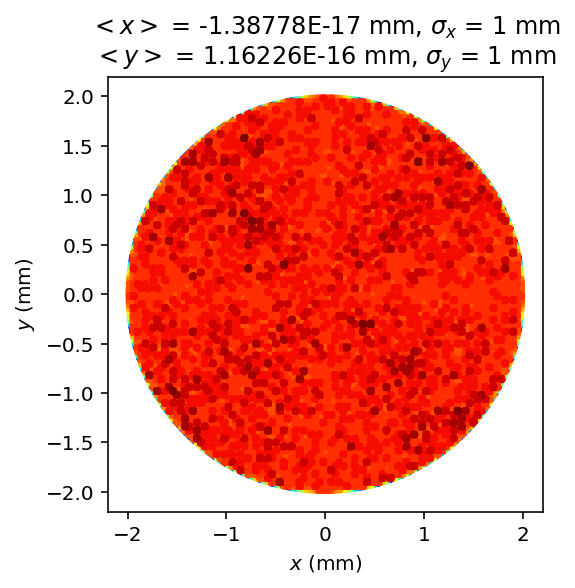

In [14]:
# The distgen module has some basic plotting routines
from distgen.plot import *

units = {'x':'mm','y':'mm','z':'mm', 'r':'mm', 
         'px':'keV/c','py':'keV/c','pz':'keV/c',
         't':'ps','q':'pC','thetax':'mrad','I':'A'}

gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

fig=plt.figure(1)
# X-Y Plot
plot_dist2d(beam,
        'x', units['x'],
        'y', units['y'],
        style='scatter_hist2d',
        nbins=100,
        axis='equal',
        title_on=True);

For plotting the histogram of the radial coordinate $r$, use `plot_radial_dist`:

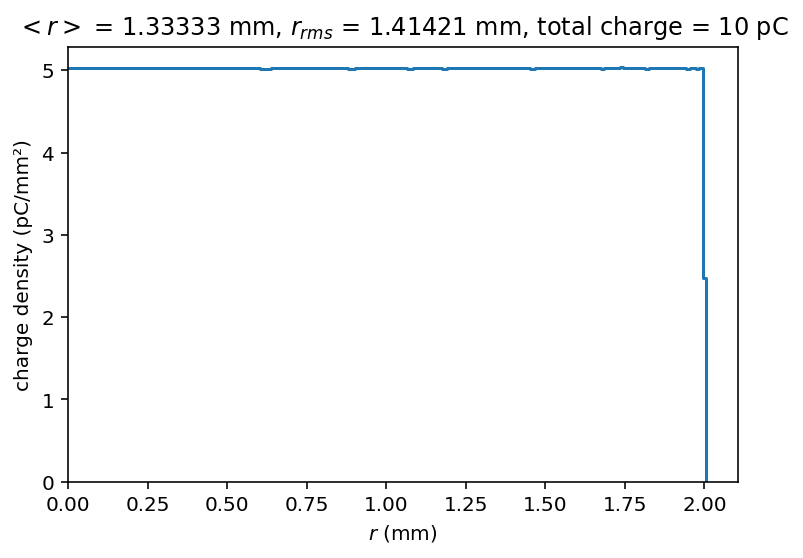

In [15]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_radial_dist(beam, units['r'], scale='charge', nbins=100, title_on=True);

For plotting 1D projections of the beam distribution, use `plot_dist1d`:

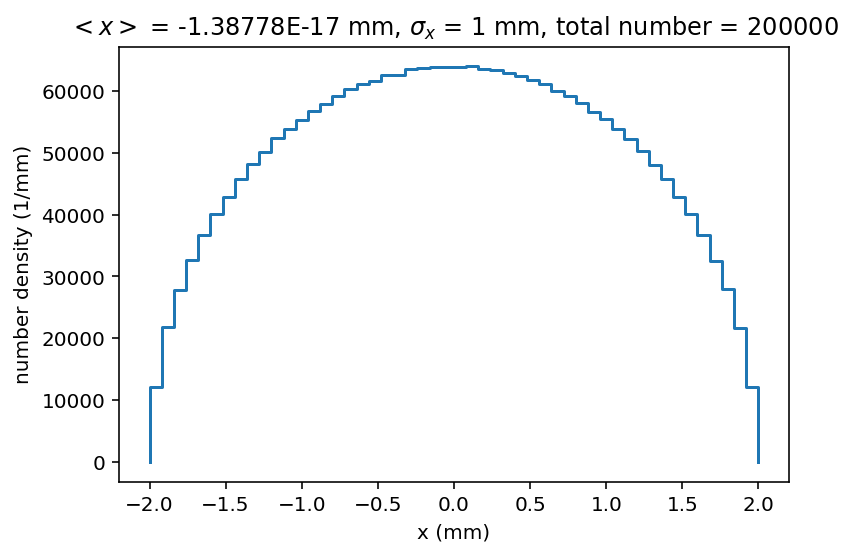

In [16]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_dist1d(beam, 'x', units['x'], scale='number', nbins=50, title_on=True)

For plotting the current profile, use `plot_current_profile`:

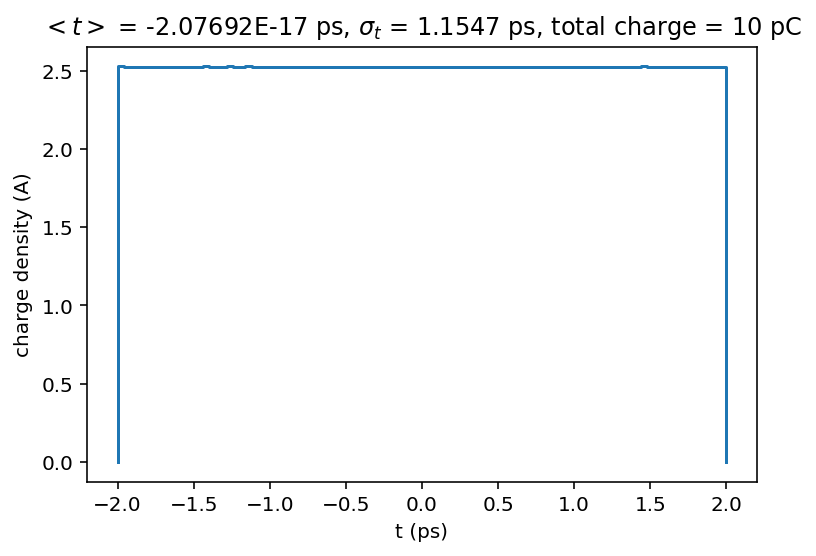

In [17]:
gen = Generator('data/beer.can.in.yaml', verbose=0) 
beam = gen.beam()

plot_current_profile(beam, units['t'], units['I'], title_on=True, nbins=100);

# Running Distgen with driver functions
The main in python driver function for distgen is `distgen.drivers.run_distgen()`.  The function creates its own Generator object and returns a beam object.  Inputs can either be an inputfile or a parsed distgen supported input dictionary.  Here the function is run with an input dictionary created above.

In [18]:
from distgen.drivers import run_distgen
beam = run_distgen(inputs=p, verbose=1)

Ignoring user specified px distribution for cathode start.
Ignoring user specified py distribution for cathode start.
Ignoring user specified pz distribution for cathode start.
Ignoring user specified px distribution for cathode start.
Ignoring user specified py distribution for cathode start.
Ignoring user specified pz distribution for cathode start.
Distribution format: gpt
Output file: beer.can.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial uniform
      min_r = 0 mm, max_r = 2 mm
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 27

Below the function is called with 'inputs' pointing to an input file.  The function can also take  accept a flattened settings dict, which updates inputs:

In [19]:
new_settings = {'start:MTE:value':0.1}
beam = run_distgen(settings=new_settings, inputs=input_file, verbose=1)

Replacing param start:MTE:value with value 0.1
Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 7.148 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 7.148 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 7.148 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.000548713 eV/c -> 0 eV/c
   Scaling sigma_px = 7.14822 eV/c -> 7.14842 eV/c
   Shifting avg_py = -0.000670353 eV/c -> 0 eV/c
   Scaling si

Finally, is also possible to run distgen as an executible script using `/bin/DistGen.py`

In [20]:
import subprocess
output=subprocess.check_output(['python','../bin/DistGen.py','-f','data/rad.gaussian.in.yaml','-v','2'])
output=str(output.decode('utf-8')).split("\n")
for line in output:
    print(line)

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shif

# Scaling/Rotating/Shifting Coordinates

The distgen module allows the user with several options for applying coordinate transformations.  Some of the basic operations include: shifting, scaling, and rotating coordinates.  See the transform.ipynb for a detailed description of this functionality. 

# Cathode Start

Currently Distgen supports a single emission model.  Particles emitted from a cathode are assumed to have a Maxwell-Boltzmann distribution for their total mometnum $p$ parameterized by an energy scale denoted $MTE$: 

$\rho_p(p) = \left(\frac{1}{2\pi mMTE}\right)^{3/2} 4\pi p^2 \exp\left(-\frac{p^2}{2m MTE}\right)$, with $\int\rho_p(p)dp = 1$.

Assuming spherical symmetry, it is easy to show the corresponding PDF for the components of the momenta is given by:

$\rho(p_x,p_y,p_z) = \left(\frac{1}{2\pi mMTE}\right)^{3/2}\exp\left(-\frac{p_x^2+p_y^2+p_z^2}{2m MTE}\right)$, with $\int\rho(p_x,p_y,p_z) d^3p=1$.

From the equipartition theorem the average energy $\frac{3}{2}MTE$ is divided equally among each direction and thus the energy scale $MTE$ can be identified as the Mean Transverse Energy: $MTE=\frac{\langle p_x^2\rangle}{2m} + \frac{\langle p_y^2\rangle}{2m}$.  

This expression can be used to relate the MTE to the initial cathode emittance:

$\epsilon_{n,x} = \sigma_{x}\sqrt{ \frac{MTE}{mc^2} }$

assuming there is no distinction between the $p_x$ and $p_y$ distributions inherent to the emission process.  To account for the fact that particles with $p_z<0$ are not emitted from the cathode, distgen takes $p_z = |p_z|$. 

So far, all of the examples shown above describes beam distributions emitted from a cathode.  The input required for cathode start is shown below:

In [21]:
from distgen import Generator
input_file = "data/rad.gaussian.in.yaml"

gen = Generator(input=input_file,verbose=1)
print('start', '=', gen.input['start'])
print('start:MTE:', '=', gen.input['start']['MTE'])

start = {'MTE': {'units': 'meV', 'value': 150}, 'type': 'cathode'}
start:MTE: = {'units': 'meV', 'value': 150}


Running the `Generator.beam()` function with `verbose` >=1 will show the stats for generation of the momenta. Note the absolute value of the $p_z$ components is taken.

In [22]:
beam = gen.beam()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -2 ps, max_t = 2 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.857 eV/c
   Shifting avg_x = -7.82345E-05 mm -> 0 mm
   Scaling sigma_x = 1.99984 mm -> 2 mm
   Shifting avg_y = -1.09911E-05 mm -> 0 mm
   Scaling sigma_y = 1.99994 mm -> 2 mm
   Shifting avg_px = -0.0212516 eV/c -> 0 eV/c
   Scaling sigma_px = 276.849 eV/c -> 276.857 eV/c
   Shifting avg_py = -0.0259627 eV/c -> 0 eV/c
   Scaling sigma_py = 276.844 eV/c -> 276.857 eV/c
   Shif

The time coordinate in this case effectively respresents the emission time of the particle from the cathode, and thus the time distribution should be set by the user.  The plots below show the corresponding horizontal and longitudinal phase spaces:

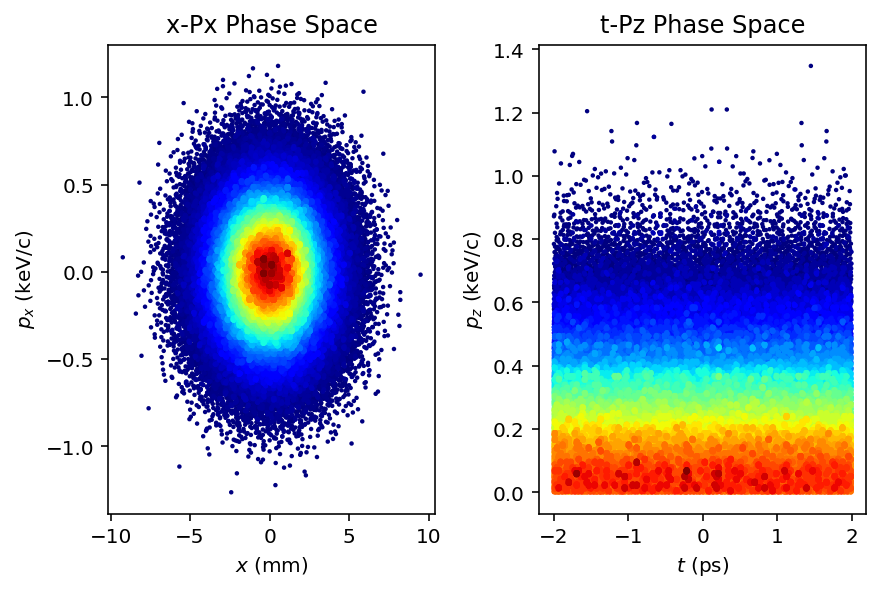

In [23]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_dist2d(beam, 'x', units['x'], 'px', units['px'], ax=ax[0]);
ax[0].set_title('x-Px Phase Space')

plot_dist2d(beam, 't', units['t'], 'pz', units['pz'], ax=ax[1]);
ax[1].set_title('t-Pz Phase Space');

# Time Start

Distgen also allows the user to start a beam at an arbitrary time.  In this case, distgen will ignore any user distribution settings for the time coordinate of the beam particles.  The example below starts with a Gaussian beam at 1 MeV:

In [24]:
filename = "data/gaussian.in.yaml"
from distgen.physical_constants import unit_registry, pi, c
gen = Generator(filename, verbose=0) 
print(gen)

<disgten.Generator with input: 
n_particle: 200000
px_dist:
  sigma_px:
    units: keV/c
    value: 1.0
  type: gaussian
py_dist:
  sigma_py:
    units: keV/c
    value: 1.0
  type: gaussian
pz_dist:
  avg_pz:
    units: GeV/c
    value: 0
  sigma_pz:
    units: MeV/c
    value: 1.0
  type: gaussian
r_dist:
  sigma_xy:
    units: mm
    value: 1.0
  type: radial_gaussian
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: pC
  value: 10
z_dist:
  avg_z:
    units: mm
    value: 0
  sigma_z:
    units: mm
    value: 2.0
  type: gaussian

>


To make this more interesting, the beam is bosted to 1 GeV, the Twiss Parameters set, and a cosine like energy spread applied:

YAML transforms input
 order:
- t1
- t2
- t3
t1:
  amplitude:
    units: GeV/c
    value: 1
  omega:
    units: gigahertz * radian * second / meter
    value: 2.724598528537186e-08
  phase:
    units: deg
    value: -1
  type: cosine z:pz
t2:
  alpha:
    units: ''
    value: -1
  beta:
    units: m
    value: 12.5
  emittance:
    units: nm
    value: 2
  type: set_twiss y
t3:
  alpha:
    units: ''
    value: -1
  beta:
    units: m
    value: 12.5
  emittance:
    units: nm
    value: 2
  type: set_twiss x


Final Horizontal Twiss params:
beta: 12500 mm, alpha: -1, eps: 2 nm

Final Vertical Twiss params:
beta: 12500 mm, alpha: -1, eps: 2 nm


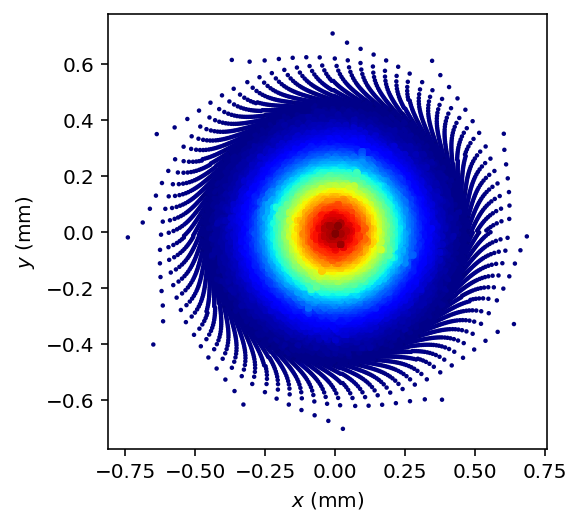

In [25]:
f = 1.3*unit_registry('GHz')
w = 2*pi*f/c

linac_params = {
    'type':'cosine z:pz',
    'amplitude':{'value':1,'units':'GeV/c'},
    'omega':{'value':w.magnitude, 'units':str(w.units)},
    'phase':{'value':-1, 'units':'deg'}
}

ybeta_params = {
    'type':'set_twiss x',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}

xbeta_params = {
    'type':'set_twiss y',
    'beta': {'value':12.5, 'units':'m'},
    'alpha':{'value':-1, 'units':''},
    'emittance':  {'value':2,'units':'nm'},
}

gen.input['transforms']={'t1':linac_params, 't2':xbeta_params, 't3':ybeta_params, 'order':['t1','t2','t3']}
beam = gen.beam()

print('YAML transforms input\n', yaml.dump(gen.input['transforms']))

print('\nFinal Horizontal Twiss params:')
print(f'beta: {beam.Beta("x"):G~P}, alpha: {beam.Alpha("x"):G~P}, eps: {beam.emitt("x","geometric").to("nm"):G~P}')
#print(f'beta: {beam.Beta("x"):G~P}, alpha: {beam.Alpha("x"):G~P}, eps: {beam.emitt("x","geometric").to("nm"):Gf~P}')

print('\nFinal Vertical Twiss params:')
print(f'beta: {beam.Beta("y"):G~P}, alpha: {beam.Alpha("y"):G~P}, eps: {beam.emitt("y","geometric").to("nm"):G~P}')

plot_dist2d(beam, 'x', units['x'], 'y', units['y'], axis='equal');

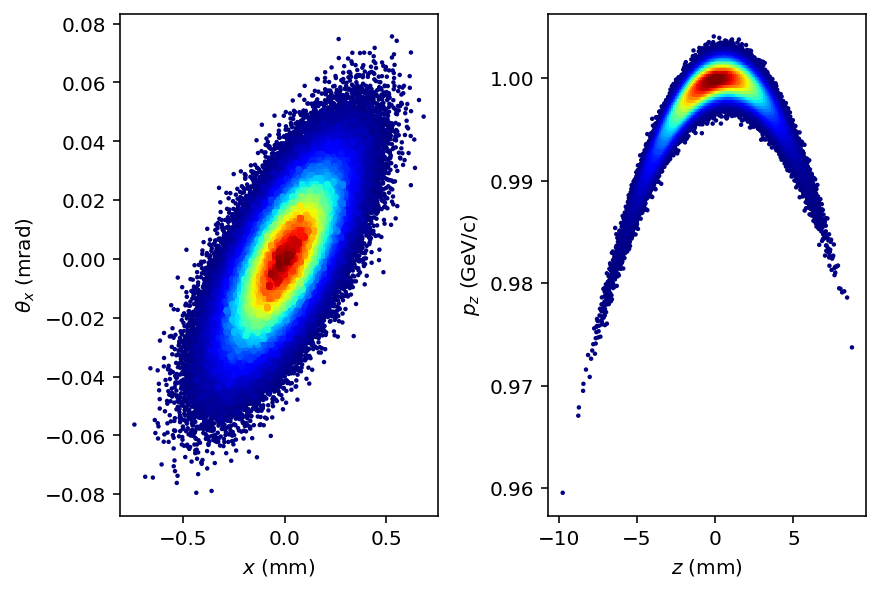

In [26]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_dist2d(beam, 'x', units['x'], 'thetax', units['thetax'], ax=ax[0]);
plot_dist2d(beam, 'z', units['z'],  'pz','GeV/c', ax=ax[1]);

# Archiving

All input and output can be saved and loaded to an hdf5 file using `.archive()` and `.load_archive` functions.

Input is archived as a flattended dict, with keys separated by `:`

Particlces are archived as openPMD-beamphysics, but only if they are created with the `run()` command.

In [27]:
gen = Generator(input_file, verbose=0) 
gen.run()

If no filename is given, a unique one will be written based on `.input`

In [28]:
afile = gen.archive()
afile

'distgen_58486ed2a099457926b362bcc04d688c.h5'

Loading into a new object

In [29]:
G2 = Generator(verbose=True)
G2.load_archive(afile)

   Reading group ./ from archive file distgen_58486ed2a099457926b362bcc04d688c.h5

open h5 handles can also be written to, using the same routine.

In [30]:
import h5py

with h5py.File('archive.h5', 'w') as h5:
    G2.archive(h5)

# Clean up
-------

In [31]:
os.remove('rad.gaussian.out.txt')
os.remove('gpt.out.txt')
os.remove('astra.out.txt')
os.remove('openPMD.out.h5')
os.remove('beer.can.out.txt')
os.remove(afile)
os.remove('archive.h5')